In [1]:
import numpy as np
from PIL import Image
import torch
from torchvision.transforms import GaussianBlur, v2, functional
import cv2
import matplotlib.pyplot as plt

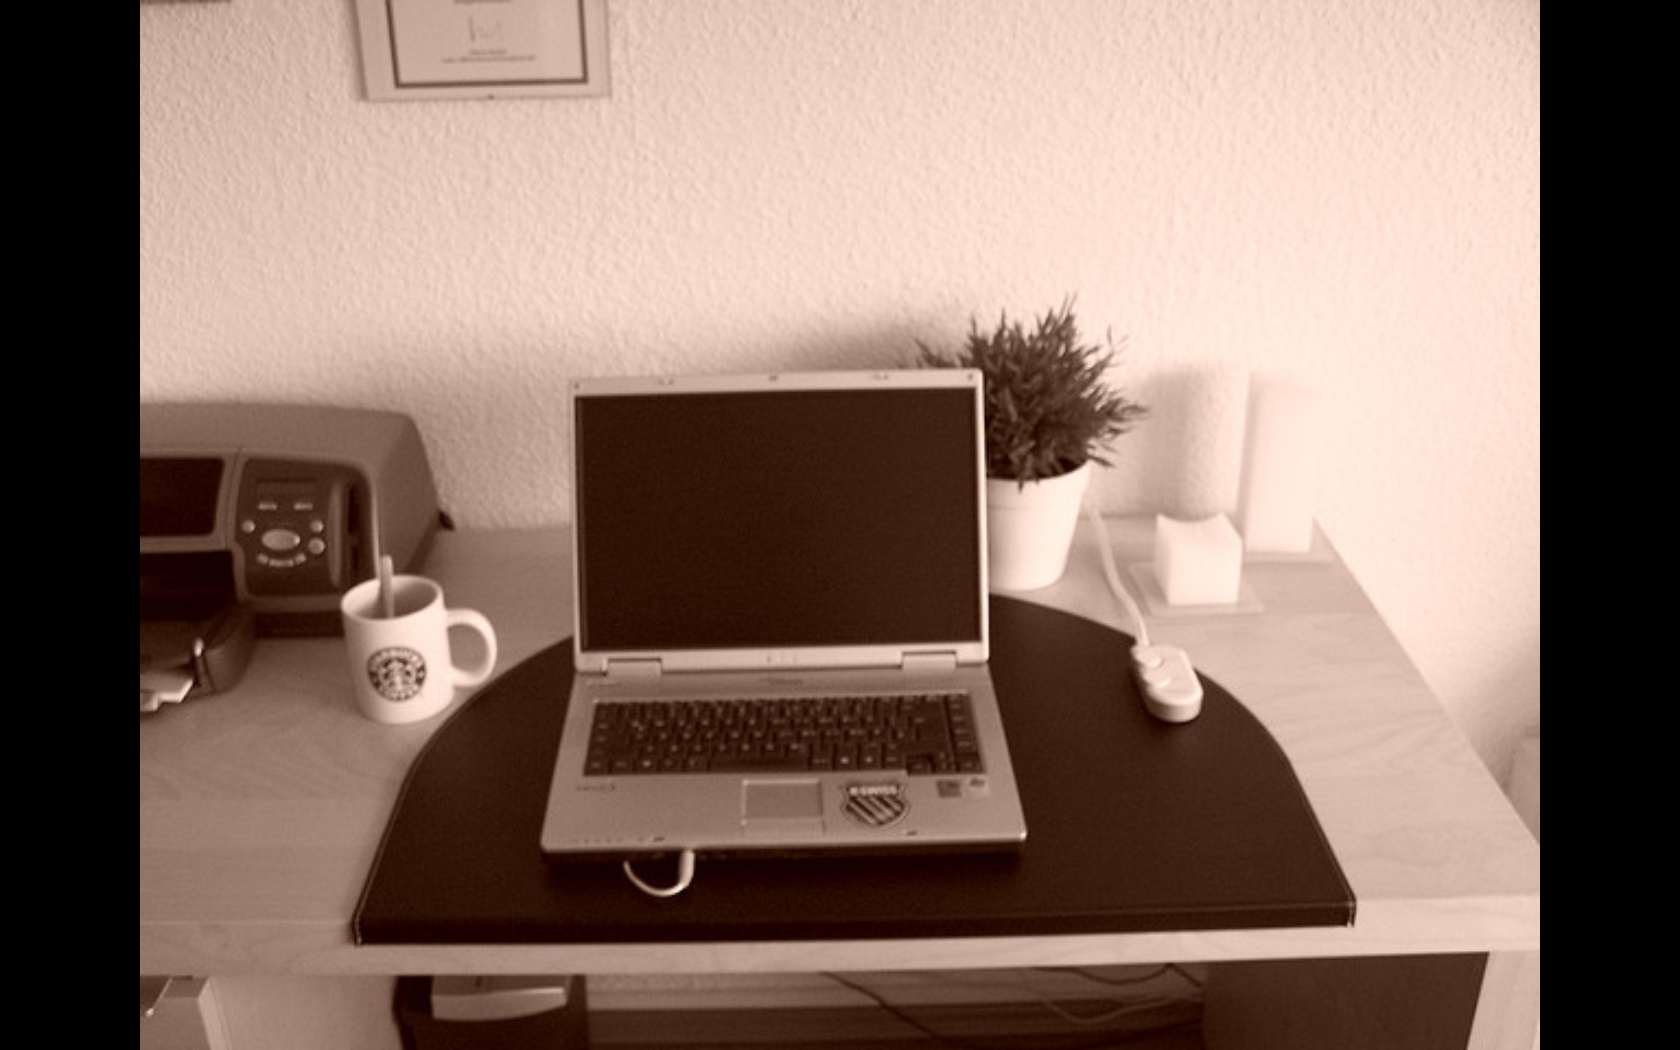

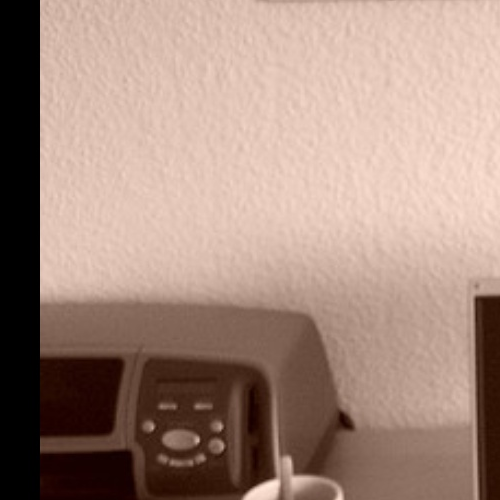

In [2]:
img=Image.open("./test_img/test6.JPEG")
display(img)
observation=v2.functional.crop(img,100,100,500,500) #top,left,height,width
display(observation)
#observation=functional.pil_to_tensor(observation)

## Numpy version

500 500
(500, 500, 3)
[[[215 186 172]
  [213 184 170]
  [211 182 168]
  ...
  [236 207 193]
  [232 203 189]
  [232 203 189]]

 [[215 186 172]
  [211 182 168]
  [209 180 166]
  ...
  [237 208 194]
  [237 208 194]
  [235 206 192]]

 [[211 182 168]
  [206 177 163]
  [208 179 165]
  ...
  [235 206 192]
  [240 211 197]
  [237 208 194]]

 ...

 [[ 94  64  53]
  [ 94  64  53]
  [ 92  64  51]
  ...
  [157 128 114]
  [157 128 114]
  [157 128 114]]

 [[ 94  64  53]
  [ 93  63  52]
  [ 92  62  51]
  ...
  [157 128 114]
  [156 127 113]
  [155 126 112]]

 [[ 96  66  55]
  [ 95  65  54]
  [ 94  64  53]
  ...
  [156 127 113]
  [154 125 111]
  [154 125 111]]]


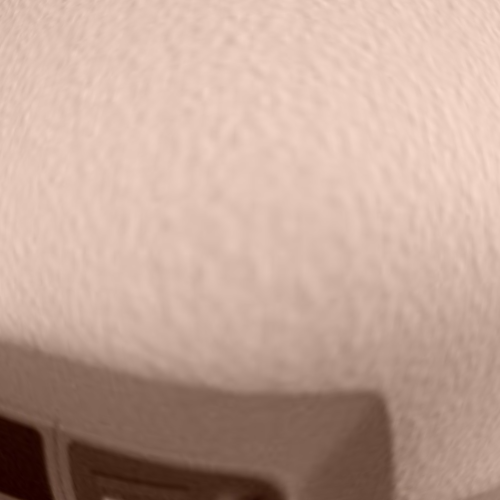

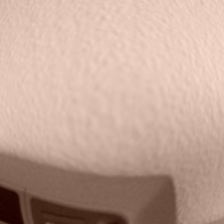

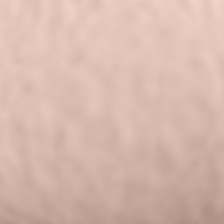

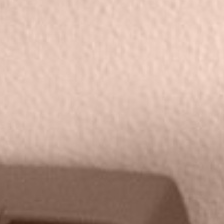

In [24]:


def nonlinear_amplify(image, alpha=2.0, beta=0.5):
    # 获取图像的高度和宽度
    height, width = image.shape[:2]
    print(height,width)

    # 计算图像中心
    center_x, center_y = width // 2, height // 2

    # 创建网格
    x, y = np.meshgrid(np.arange(width), np.arange(height))

    # 计算到中心的距离
    distances = np.sqrt((x - center_x) ** 2 + (y - center_y) ** 2)

    # 计算放大因子
    factors = 0.2 + alpha * np.exp(-beta * distances)

    # 计算新的像素位置
    new_x = center_x + (x - center_x) * factors
    new_y = center_y + (y - center_y) * factors

    # 使用双线性插值
    map_x = new_x.astype(np.float32)
    map_y = new_y.astype(np.float32)

    # 重新映射像素值
    amplified_image = cv2.remap(image, map_x, map_y, interpolation=cv2.INTER_LINEAR)
    print(amplified_image.shape)

    return amplified_image,map_x,map_y

# 读取图像
image = np.asarray(observation)
#image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

# 进行中心位置的非线性放大
#amplified_image,map_x,map_y = nonlinear_amplify(image, alpha=2.5, beta=0.005)

amplified_image,map_x,map_y = nonlinear_amplify(image, alpha=0.1, beta=-0.005)

# 显示原始图像和
display(Image.fromarray(amplified_image))
display(functional.resize(Image.fromarray(amplified_image), 224))
display(functional.center_crop(Image.fromarray(amplified_image), output_size=(224,224)))
display(functional.center_crop(observation, output_size=224))


## torch implementation

(3, 500, 500)
torch.Size([3, 224, 224])


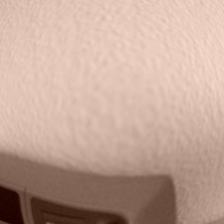

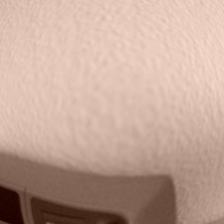

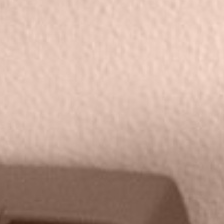

In [44]:
import torch.nn.functional as F

def foveate_transform(image, output_size, alpha=2.0, beta=0.5):
    # Input [C, H, W]
    assert image.shape[0] == 3
    height, width = image.shape[1:]

    center_x, center_y = width // 2, height // 2

    # Create meshgrid and calculate distances in a vectorized way
    y, x = np.ogrid[:height, :width]
    distances = np.sqrt((x - center_x) ** 2 + (y - center_y) ** 2)

    # Calculate scaling factors
    factors = 0.2 + alpha * np.exp(-beta * distances)

    # Apply transformation in a vectorized way
    new_x = center_x + (x - center_x) * factors
    new_y = center_y + (y - center_y) * factors

    # Normalize coordinates to the range [-1, 1] for grid_sample
    new_x = (new_x / (width - 1)) * 2 - 1
    new_y = (new_y / (height - 1)) * 2 - 1

    # Stack and reshape to form a grid of shape [1, H, W, 2]
    grid = np.stack((new_x, new_y), axis=-1)
    grid = torch.tensor(grid, dtype=torch.float32).unsqueeze(0)

    # Convert image to tensor and add batch dimension
    image = torch.tensor(image, dtype=torch.float32).unsqueeze(0)

    # Apply grid_sample
    trans_image = F.grid_sample(image, grid, mode='bilinear', align_corners=True)

    # Resize the image to the output size
    trans_image = F.interpolate(trans_image, size=(output_size, output_size), mode='bilinear', align_corners=True)

    # Remove batch dimension and convert to [C, H, W]
    trans_image = trans_image.squeeze(0)

    return trans_image

image = np.asarray(observation).transpose(2,0,1)
print(image.shape)
#image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

amplified_image = foveate_transform(image, output_size=224, alpha=0.1, beta=-0.005).to(torch.uint8)


# 显示原始图像和
print(amplified_image.shape)

display(functional.to_pil_image(amplified_image))
#display(functional.to_pil_image(functional.resize(amplified_image, 224)))
display(functional.to_pil_image(functional.center_crop(amplified_image, output_size=(224,224))))
display(functional.center_crop(observation, output_size=224))
